In [25]:
from pathlib import Path
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import torch
sns.set_style("whitegrid")


results_path = Path("/Users/Matey/project/fact8/benchmarks/results/")
mcts_path = Path("/Users/Matey/project/fact8/tgnnexplainer/xgraph/saved_mcts_results/")


## TGAT
### Wikipedia

In [49]:
tgat_wikipedia_xtg = (
    results_path
    / "tgat_wikipedia_subgraphx_tg_110314_to_155614_eval_pg_true_pg_positive.csv"
)

tgat_wikipedia_attn = (
    results_path / "tgat_wikipedia_attn_explainer_tg_110314_to_155614_eval.csv"
)


tgat_wikipedia_pbone = (
    results_path / "tgat_wikipedia_pbone_explainer_tg_110314_to_155614_eval.csv"
)

tgat_wikipedia_pg = (
    results_path / "tgat_wikipedia_pg_explainer_tg_110314_to_155614_eval.csv"
)

tgat_wikipedia_xtg = pd.read_csv(tgat_wikipedia_xtg).groupby("sparsity").mean()
tgat_wikipedia_attn = pd.read_csv(tgat_wikipedia_attn).groupby("sparsity").mean()
tgat_wikipedia_pbone = pd.read_csv(tgat_wikipedia_pbone).groupby("sparsity").mean()
tgat_wikipedia_pg = pd.read_csv(tgat_wikipedia_pg).groupby("sparsity").mean()
tgat_wikipedia_tabs = [tgat_wikipedia_xtg, tgat_wikipedia_attn, tgat_wikipedia_pbone, tgat_wikipedia_pg]

tgat_wikipedia_best_fids = [tab['fid_inv_best'].max() for tab in tgat_wikipedia_tabs]
tgat_wikipedia_aufsc = [np.trapz(tab['fid_inv_best'], tab.index) for tab in tgat_wikipedia_tabs]
print("Best Fid:", tgat_wikipedia_best_fids)
print("AUFSC:", tgat_wikipedia_aufsc)

Best Fid: [1.5818624862562864, 0.8115232364814728, 1.259748881770298, 0.586134309662506]
AUFSC: [1.260553622080013, 0.5135449815198778, 0.8691429810960776, -0.65028520664121]


TGNN-X	 FID: 1.5818624862562864 	 AUC: 1.260553622080013
ATTN	 FID: 0.8115232364814728 	 AUC: 0.5135449815198778
PBONE	 FID: 1.259748881770298 	 AUC: 0.8691429810960776
PG	 FID: 0.586134309662506 	 AUC: -0.65028520664121


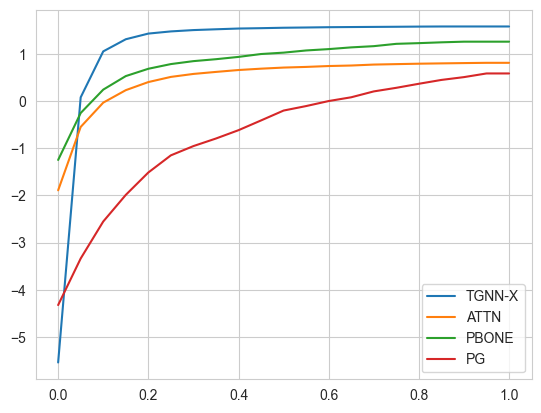

In [46]:
for tab, label in zip(tgat_wikipedia_tabs, ['TGNN-X', 'ATTN', 'PBONE', 'PG']):
    print(f"{label}\t FID: {tab['fid_inv_best'].max()} \t AUC: {np.trapz(tab['fid_inv_best'], tab.index)}")
    plt.plot(tab.index, tab['fid_inv_best'], label=label)
plt.legend();

## Simulate V1

In [ ]:
tgat_simulate_v1_xtg = (
    results_path
    / "tgat_simulate_v1_subgraphx_tg_110314_to_155614_eval_pg_true_pg_positive.csv"
)

tgat_simulate_v1_attn = (
    results_path / "tgat_simulate_v1_pbone_explainer_tg_10_to_16009_eval.csv"
)

tgat_simulate_v1_pbone = (
    results_path / "tgat_simulate_v1_pbone_explainer_tg_10_to_16009_eval.csv"
)

tgat_simulate_v1_pg = (
    results_path / "tgat_simulate_v1_pbone_explainer_tg_10_to_16009_eval.csv"
)

tgat_simulate_v1_xtg = pd.read_csv(tgat_simulate_v1_xtg).groupby("sparsity").mean()
tgat_simulate_v1_attn = pd.read_csv(tgat_simulate_v1_attn).groupby("sparsity").mean()
tgat_simulate_v1_pbone = pd.read_csv(tgat_simulate_v1_pbone).groupby("sparsity").mean()
tgat_simulate_v1_pg = pd.read_csv(tgat_simulate_v1_pg).groupby("sparsity").mean()
tgat_simulate_v1_tabs = [
    tgat_simulate_v1_xtg,
    tgat_simulate_v1_attn,
    tgat_simulate_v1_pbone,
    tgat_simulate_v1_pg,
]

best_fids = [tab["fid_inv_best"].max() for tab in tgat_simulate_v1_tabs]
aufsc = [np.trapz(tab["fid_inv_best"], tab.index) for tab in tgat_simulate_v1_tabs]
print("Best Fid:", best_fids)
print("AUFSC:", aufsc)

In [34]:
mcts_node_info = sorted(mcts_path.glob("*simulate_v1_73*"))[-1]
node_info = torch.load(mcts_node_info)
node_info = node_info['saved_MCTSInfo_list'] # there is only one key in the dict
node_info[0], node_info[-1]

({'coalition': [7327,
   7330,
   7331,
   7333,
   7334,
   7335,
   7336,
   7337,
   7338,
   7339,
   7341,
   7342,
   7343,
   7344],
  'created_by_remove': 7346,
  'c_puct': 100,
  'W': -4.936435222625732,
  'N': 1,
  'P': -8.270224571228027,
  'Sparsity': 0.7},
 {'coalition': [7330, 7334, 7335, 7339, 7341, 7344, 7345],
  'created_by_remove': 7340,
  'c_puct': 100,
  'W': -19.74574089050293,
  'N': 4,
  'P': 1.433377981185913,
  'Sparsity': 0.35})

# Runtime comparison

In [50]:
# seconds
training_runtimes = {
    # simulate_v1, simulate_v2, wikipedia, reddit
    "TGAT": [5.0, 6.1, 93, 627.23],
    "TGN": [18.1, 4.2, 84.7, 614],
}


candidate_scores_path = results_path / "candidate_scores"
scores = {}
not_found = []
for model in ["tgat", "tgn"]:
    scores[model] = {}
    for dataset in ["simulate_v1", "simulate_v2", "wikipedia", "reddit"]:
        try:
            scores[model][dataset] = pd.read_csv(
                next(candidate_scores_path.glob(f"*{model}_{dataset}*"))
            )["runtime"].mean()
        except (KeyError, StopIteration):
            not_found.append(f"{model}_{dataset}")
            continue

print("Not found:", not_found)

# explain_runtimes = {"TGAT": scores, "TGN": {"Reddit": []}}
scores
# df = pandas.DataFrame.from_dict(dictionary, orient="index").stack().to_frame()
# # to break out the lists into columns
# df = pandas.DataFrame(df[0].values.tolist(), index=df.index)

Not found: ['tgat_simulate_v1', 'tgat_simulate_v2', 'tgn_wikipedia']


{'tgat': {'wikipedia': 33.06484191560745, 'reddit': 75.92333634567261},
 'tgn': {'simulate_v1': 15.013805898666382,
  'simulate_v2': 22.50646854686737,
  'reddit': 45.30789113235473}}

75.92333634567261